<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/group_svm/Young_Adult_Group_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Young Adult Group Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- This notebook goes from the pre-processed raw data in MATLAB:
  - loading from storage in AWS
  - masks the data
  - normalizes data by run
  - splits the subjects into train validation and test sets where there is no 
    crossing of subjects to control for data leakage.
  - trains the data and saves model, data values and metrics to AWS

SVM training per group (subject ids of '100XX-XXXXX' for Adolescent (child) and '300XX-XXXXX' for Young Adult)

- CURRENT RUN: ZNORM, MASK

### Mount Google Drive and clone repository
- open to source directory

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')#, force_remount = True)

# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source/group_svm
!ls


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

### Import libraries


In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from visualize import *
from train import run_grp_svm_model
from analysis import create_bmaps, get_threshold_image, metrics, get_roi_bmaps
from process import *
from access_data import *

from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

#Part I:
      Perform subject splitting into Young Adults
      Load saved pre-processed data from AWS 
                - or -
      Apply mask to .MAT data and filter data by labels
      Transform Data by:
          - Scaling data per run per subject based on normalization type
            (Z-score, Percent Signal Change or No Normalization)
          - Detrend the time series per run per subject
          - Concatenate the Training and Test Data (We can apply a Validation 
            set but not needed since we performed Cross Validation on the 
            Validation set prior for model tuning)
          - Train sklearn.svm.SVC with Params: C: 10; gamma: 'auto', 
            class_balanced, and max_iter = 1000
          - Collect metrics: Accuracies, probabilities, classification report
            and save into a dictionary and uploading to S3. 

#### If you wish to skip ahead, please jump to **Part II** where we can load in the metrics data to visualize the brain data. Performance metric visualization is performed in a separate notebook called **Group_analysis.ipynb** in this current directory.  


## Load Unmasked Data from AWS
- normalize and transform data
- and obtain Young Adult subjects from last 19 subject IDs

In [ ]:
%%time
# Get mat file 
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'// 'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
label_type = 'rt_labels' 
from_mat = 'unnorm' #unnorm
data_type = "YA_detrend"
m_path_ind = 0 #get sub_mask data in mask_data key. // 1 is ROI
l_path_ind = 0 #get data in data from rt_label key

#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)
data_path = "data/"
filename = f"all_data_{mask_type}_{from_mat}_2d.pkl"
subject_ids = data_path_dict['subject_ID']

# Split dataset into Young Adult
ya = subject_ids[33:]
print("Number of subjects for Young Adult ", len(ya))

# process data if not in AWS already
obj_name, _, _ = access_aws()
statement = False
for i in obj_name:
  if filename in i.key:
    statement = True 

if statement == False:
  print("Masking mat data...")
  data = masked_data_n_labels(mask_type, label_type, data_path_dict, m_path_ind, l_path_ind) 
  print(f"Saving data to local path {data_path}{filename}")
  f = open(f"{data_path}{filename}", "wb")
  pickle.dump(data, f)
  f.close()
else:
  print("Loading in masked data")
  data = access_load_data(filename, False)

Number of subjects for Young Adult  19
Loading in masked data
CPU times: user 28.9 s, sys: 31.1 s, total: 60 s
Wall time: 1min 21s


## SVM Young Adult
- Split subject IDs three ways to make Train, Val, Test sets
- Perform Z-Normalization on the data per run per subject by calling transform_data()
- Run SVM on PSC and Z-normalized Data
- Train/Val/Test set run 2 and 3

In [ ]:
# get train, test data
train_ids = ya[:15]
#val_ids = ya[13:16]
test_ids = ya[15:19]

data_type = "YA_detrend"
group_sub_ids = (train_ids, False, test_ids)
runs_train = [1,2] # grabs the second run
runs_val = False
runs_test = [1,2] #2 # grabds the third run
norm = "Detrend_Znorm" # "RUNS" Normalizes per run; "SUBJECT" Normalized all runs for a given subject; False - no normalization

print("Number of Young Adult training examples: ", len(train_ids))
#print("Number of Young Adult validation examples: ", len(val_ids))
print("Number of Young Adult testing examples: ", len(test_ids))
print(len(ya))

run_grp_svm_model(data, mask_type, group_sub_ids, runs_train, runs_val, runs_test, norm, data_type, m_path_ind)

#Part II:
## Visualization Analysis
      Load saved metrics for a given brain mask and extract 
      bmap 
      y labels 
      alpha values 

      If we are loading in the whole brain mask, we will also load in mask
      indices for regions of interest in which we want to apply as a mask
      overlay on top of the whole brain data. This will visually block out all
      areas of the brain other than the region of interest we wish to
      highlight. 
      
      - Plot the brain mask data using Nilearn's plot_img package
      - Visualize the decision function time series with y labels
      - Visualize a histogram of that represents essentially the decision
        function by plotting where voxels are in the positive or negative class
        and highlights the data where they have been mislabeled.
      - Save plots locally

**Creating the bmaps** 
        
        
      - We find the support vectors and indices from our model
        using .support_ and the weights of our model using 
        .dual_coef_. 
      - We create a dummy 3D image in the shape of our X   
        train data and store our weights in this matrix but
        only at the significant indices where our support
        vectors were found. This is what we call our alpha  
        matrix. 
      - Take the dot product of the alpha matrix (support
        vector weights) and the X train matrix. This is what we
        call our beta matrix. 
      - Then we map this matrix full of values back to the 
        original brain space of (79,95,79) using the indices of 
        our applied mask. 
      - There are many steps of reshaping the data in these 
        steps and the results were double checked on MATLAB 
        software to ensure accurate mapping. 
      - The final beta matrix is then converted to a NIFTI file 
        for use with the Nilearn image package. 
        

In [125]:
# Load model
#open path dictionary file to get subject ids
dict_path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(dict_path)

mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "YA_detrend"
runs_train = [1, 2]
runs_id = [i + 1 for i in runs_train]
m_path_ind = 0 #get sub_mask data in mask_data key
metric_data = access_load_data(f'metrics/group_svm/{mask_type}/{data_type}_{runs_id}_{mask_type}_metrics.pkl', False)
print(metric_data.keys())


dict_keys(['bmap3', 'bmap2_3', 'alphas1', 'bmap', 'y_train', 'test_preds', 'test_probs', 'test_acc', 'test_dfunc', 'y_t'])


#### Load Beta map for Visualization
- Create/load Alphas and Bmaps for Region of Interest
          We will look at:
            - Whole Brain Mask
            - medial Prefrontal Cortex
            - Nucleus Accumbens


In [94]:
# Load in affine matrix - helps map the data coordinates to real world coordinates
affine_image = access_load_data('w3rtprun_01.nii',False)
t1_image = access_load_data('MNI152.nii',False)

> Whole Brain Interactive voxel map


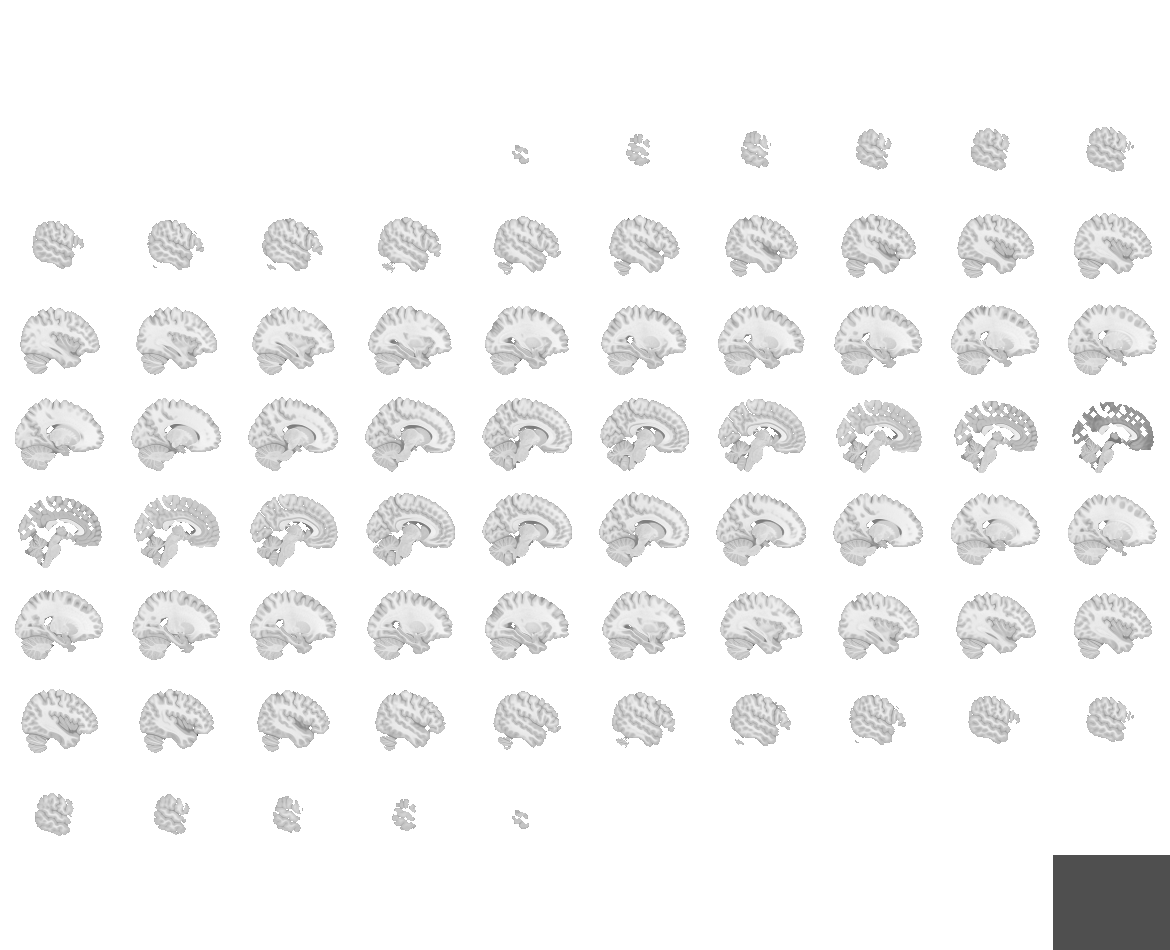
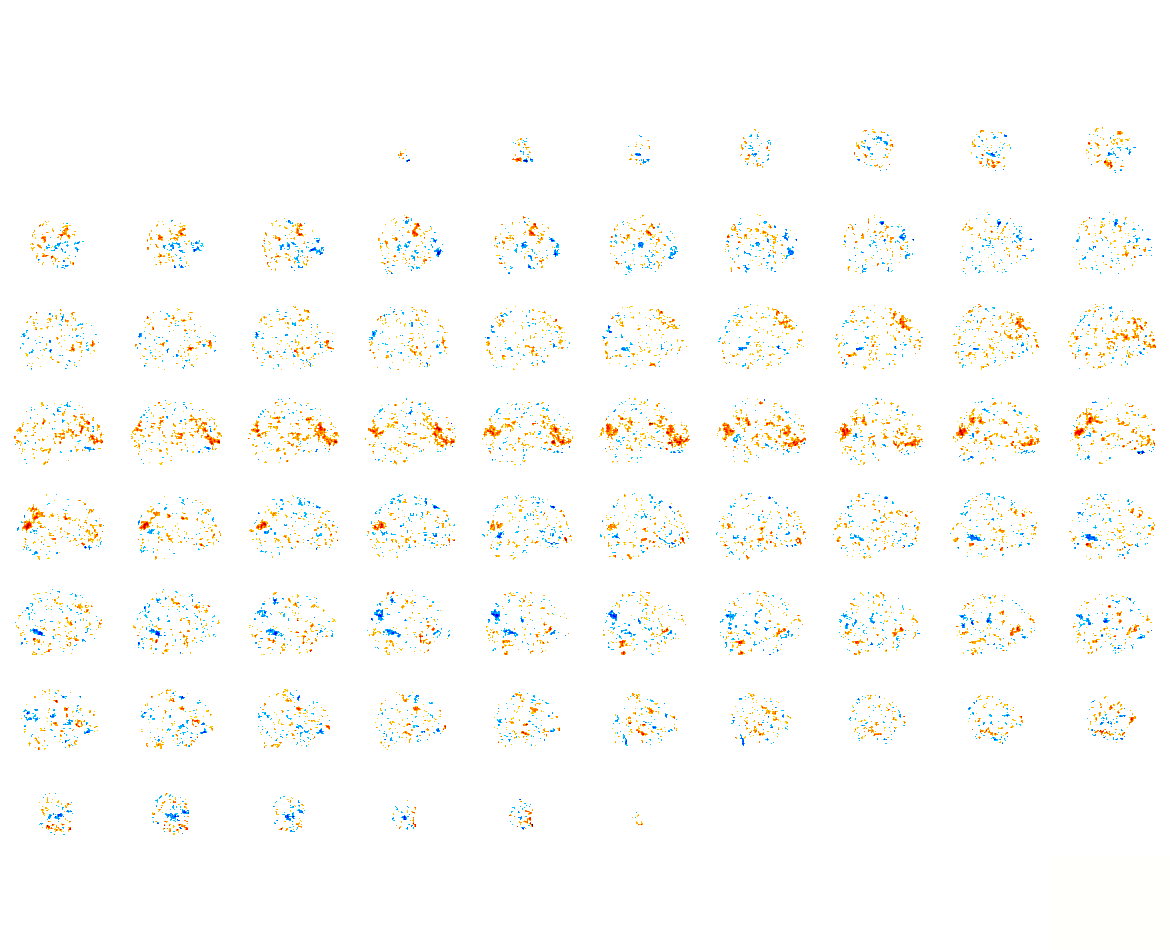

In [98]:
# Plot interactive maps     
html_view = plotting.view_img(metric_data['bmap3'][0], 
                              #bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              cut_coords=(4, -78, 20),#[-10, 13, -8],
                              black_bg = False,
                              draw_cross = True,
                              title=f"Young Adult Whole Brain")#{mask_type}")
html_view#.save_as_html(f'/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_1.html')

> Isolating the Medial Prefrontal Cortex Region of Interest using data trained on whole brain

In [103]:
# Load in the mask indices for mask overlay to create bmaps of a specific Region of interest
roi_path_ind = 1 # get mask data for region of interest
mask_roi = 'mPFC' #'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
indices_mask = load_mask_indices(data_path_dict, mask_roi, roi_path_ind)

previous_bmap_data = metric_data['bmap2_3'][0]
bmap3pfc = get_roi_bmaps(previous_bmap_data, indices_mask, affine_image)

# Plot interactive maps     
html_view = plotting.view_img(bmap3pfc, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              #cut_coords=(1, 55, -22),#[-10, 40, 20],#[-10, 13, -8],
                              black_bg = False,
                              draw_cross = False,
                              title=f"Young Adult Medial PFC",
                              resampling_interpolationst = 'continuous'
                              )#{mask_type}")
html_view.save_as_html(f'/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_roi}_nocross.html')

mask shape: (79, 95, 79)




> Isolate the Nucleus Accumbens in Whole Brain data



In [106]:
# Load in the mask indices for mask overlay to create bmaps of a specific Region of interest
roi_path_ind = 1 # get mask data for region of interest
mask_roi = 'nacc_aal' #'acc_aal', 'anterior_insula_aal', 'mPFC', 'nacc_aal', 
indices_mask = load_mask_indices(data_path_dict, mask_roi, roi_path_ind)

previous_bmap_data = metric_data['bmap2_3'][0]
bmap3nacc = get_roi_bmaps(previous_bmap_data, indices_mask, affine_image)

# Plot interactive maps     
html_view = plotting.view_img(bmap3nacc, 
                              bg = t1_image, 
                              scale_loc = 3,
                              threshold='95%', 
                              cmap = 'cold_white_hot', 
                              #cut_coords=(1, 55, -22),#[-10, 40, 20],#[-10, 13, -8],
                              black_bg = False,
                              draw_cross = False, 
                              title=f"Young Adult NAcc"
                              )#{mask_type}")
html_view.save_as_html(f'/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_roi}_nocross.html')

mask shape: (79, 95, 79)


> Let's Plot Whole Brain Slices 

In [ ]:
# View Slices of the brain
# get bmaps for visualization
mask_type = 'mask' #'mask', 'masksubACC', 'masksubAI', 'masksubNAcc', 'masksubmPFC'
data_type = "YA_detrend"
msk_type = 'Whole Brain'
bmap3 = metric_data['bmap3'][0]

outfile = True

if outfile == None:
  output_file = None
else:
  output_file = f"/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_plt_z_1.png"

  title = f"Young Adult {msk_type}"
  im = plotting.plot_img(bmap3, 
                          #bg_img = t1_image,
                          #title = title,
                          colorbar=True, 
                          black_bg = False, 
                          cut_coords = (-35,-20,0,20,35,50,65,70),
                          cmap='cold_white_hot', 
                          display_mode='z',
                          output_file = output_file
                          )

> Plot Whole Brain with Thresholds
  - Score Percentile threshold 
  - Image Intensity threshold

In [ ]:
# Plot Stat maps using thresholds for signal intensity values
score_percentile = '98%' # threshold by top 2% and bottom 2%
image_intensity = 3.0
threshold_percentile_img, threshold_value_img = get_threshold_image(bmap3, score_percentile, image_intensity)

outfile = True
if outfile == None:
  output_file = None
else:
  output_file1 = f"/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_percent_statmap_y_1.png"
  output_file2 = f"/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_intensity_statmap_y_1.png"


title2=f'Percentile Signal threshold Young Adult {mask_type} at {score_percentile}'
title3=f'Image intensity threshold at {image_intensity} Young Adult {mask_type}'
# Plotting image thresholded by percentile
im2 = plotting.plot_stat_map(threshold_percentile_img,
                        title = title2 ,
                        bg_img = t1_image, 
                        display_mode='y', 
                        black_bg = False, 
                        cut_coords= (-35,-20,0,20,35,50,65,70),
                        colorbar=True,
                        #annotate = False,
                        cmap = "cold_white_hot",
                        output_file=output_file1
                       )

# Showing intensity threshold image
im3 = plotting.plot_stat_map(threshold_value_img, 
                        title = title3,
                        bg_img = t1_image, 
                        black_bg = False, 
                        display_mode='y', 
                        cut_coords= (-35,-20,0,20,35,50,65,70), 
                        colorbar=True,
                        cmap = "cold_white_hot",
                        output_file=output_file2
                       )

"im3.title(title3, \n          x=0.01, \n          y=0.99, \n          size=15, \n          color='black', \n          bgcolor='w'\n          )"

> Plot X, Y, Z Slice to Highlight a large area of activation in the data. The Visual Cortex has been shown to be significant in the task fMRI. Further analysis might include masking out the visual cortex prior to model training. 

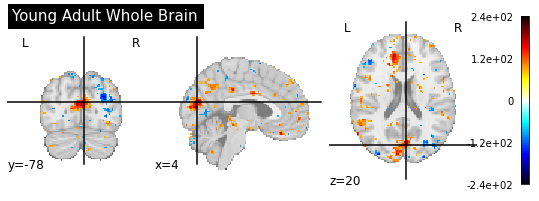

In [ ]:
# Plotting all slices in brain
title = f'Young Adult Whole Brain'
output_file3 = f"/content/gdrive/MyDrive/YA_viz_notebook/{data_type}_{mask_type}_xyz.png"
plotting.plot_stat_map(bmap3, #threshold_percentile_img, 
                       #bg_img = t1_image, 
                       #display_mode='z', 
                       cut_coords=(4, -78, 20), 
                       annotate = True,
                       title=title, 
                       colorbar=True,
                       black_bg = False,
                       cmap = "cold_white_hot",
                       #output_file=output_file3
                       )

> Plot SVM Decision Function values

In [6]:
# Create a DataFrame from metrics of Whole Brain
decision_scores = metric_data['test_dfunc'][0]
y = metric_data['y_t'][0]

time = np.arange(0, len(decision_scores), 1)
d = {}
d['time'] = time
d['score'] = decision_scores
d['true'] = y
df = pd.DataFrame(d)
df

,time,score,true
0,0,-0.076048,1
1,1,0.288541,1
2,2,0.410848,1
3,3,-0.061933,1
4,4,0.134696,1
...,...,...,...
667,667,-0.162315,0
668,668,-0.147932,0
669,669,0.016314,0
670,670,-0.100496,0


In [132]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np


#x_axis=list(range(df.shape[0]-1))
#y_axis=list(df['score'].values)

#framess=[]
#for frame in range(1,672):
    #x_axis_frame=np.arange(frame)
    #print(x_axis_frame)
y_axis_frame=list(df['score'].values[:300])
y_axis=list(df['score'].values[:300])
y_ax=list(df['score'].values)
x_axis_framestart = np.arange(0, 300, 1)    
x_axis_frame = np.arange(0, 300, 1)
framess=[]
for frame in range(300,673):
    x_axis_frame = np.append(x_axis_frame, frame)
    x_axis_frame = x_axis_frame[1:]
    
    y_axis_frame=np.append(y_axis_frame, y_ax[frame-1])
    y_axis_frame = y_axis_frame[1:]
    curr_frame=go.Frame(data=[go.Scatter(x=x_axis_frame,y=y_axis_frame,mode='lines')])
    framess.append(curr_frame)
  
figure=go.Figure(
    data=[go.Scatter(x=x_axis_framestart,y=y_axis,mode='lines')],
    layout={"title":"Young Adult Decision Scores",
    "updatemenus":[{"type":"buttons",
                    "buttons":[{"method":"animate",
                                "label":"play", 
                                "args":[None, {"frame": {"duration": 10, 
                                                         "redraw": True},
                                                         "fromcurrent": False, 
                                                         "transition": {"duration": 10, 'easing': 'quadratic-in-out'}
                                               }
                                        ]
                                }]
                    }],
            "xaxis":{"title":"Timepoints [volumes]"},
                     #"range":[0,len(df)+5]},
            "yaxis":{"title":"Decision scores from SVM model",
                     "range":[-2,2]}
                    },
    frames=framess)
figure.write_html("/content/gdrive/MyDrive/YA_viz_notebook/file.html")
figure.show()


> Timeseries of Decision Scores over subjects. In this case we have chosen to show Young Adult subjects 1 and 2 for runs 2 and 3. 

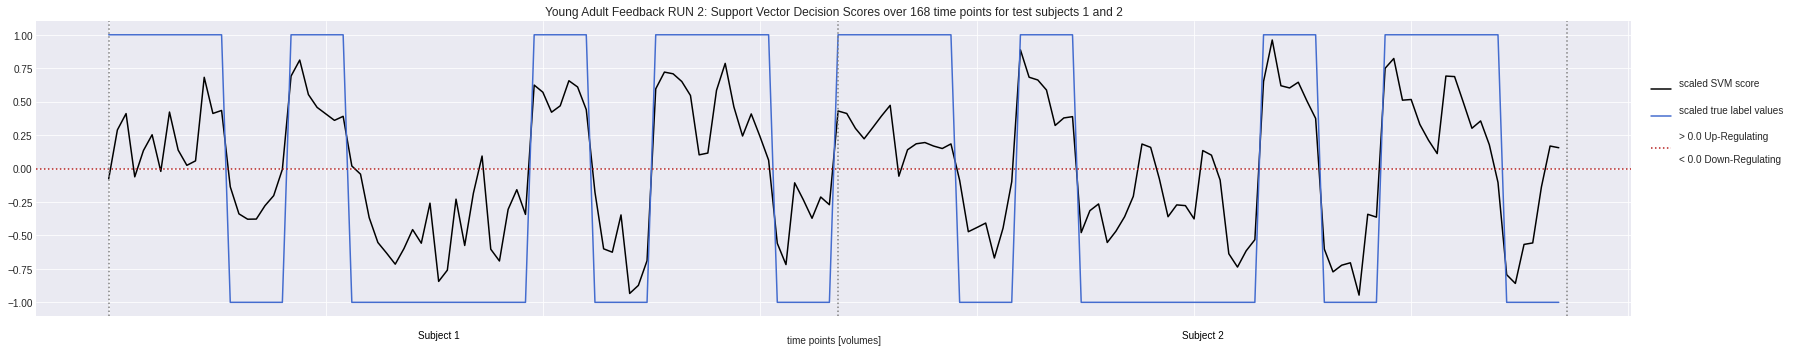

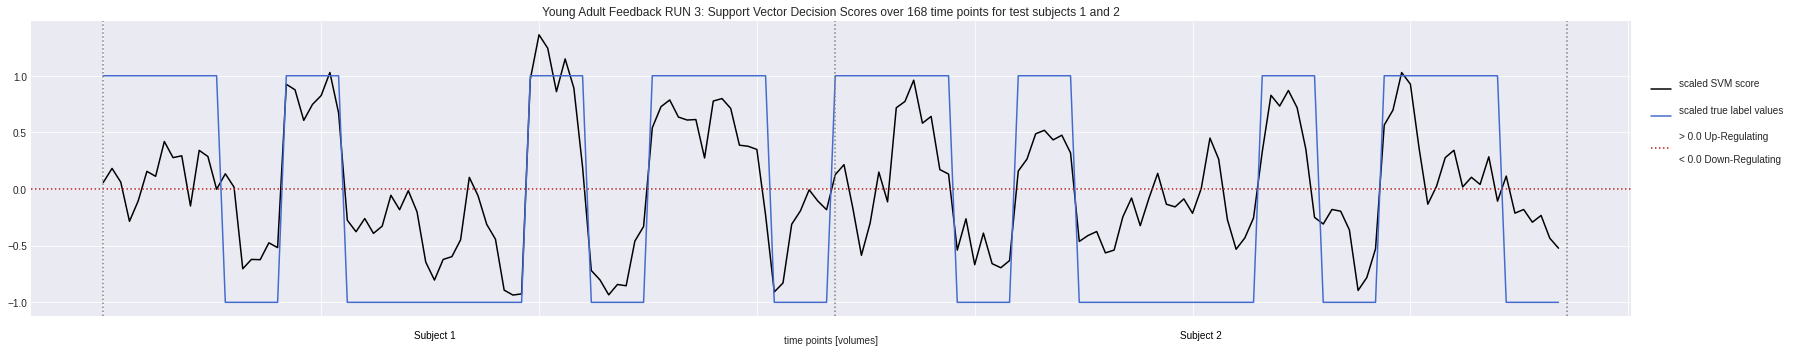

In [133]:
# Create a DataFrame from metrics of Whole Brain
decision_scores = metric_data['test_dfunc'][0]
y = metric_data['y_t'][0]

# Plot the time series with SVM decision scores and labels
filerun2 = f'/content/gdrive/MyDrive/YA/YA_wb_run2_dfunc_line.png'
filerun3 = f'/content/gdrive/MyDrive/YA/YA_wb_run3_dfunc_line.png'
timepoints = [(0, 168, -1.0, 1.0, "Young Adult Feedback RUN 2", filerun2),
              (336, 504, -1.0, 1.0, "Young Adult Feedback RUN 3",filerun3)
              ] 
for start, stop, min, max, run, file in timepoints:
  time = stop - start
  labels = np.where(y == 0,min,max)
  plot_decisions(decision_scores[start:stop],labels[start:stop], time, title, mask_type, run, file)

> Plot the histogram of decision scores made by the SVM

Saving /content/gdrive/MyDrive/YA_viz_notebook/YA_decision_hist.png...


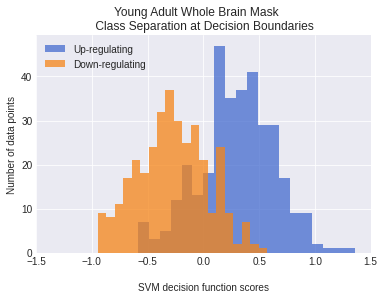

In [108]:
y_decision_score = metric_data['test_dfunc'][0] # Decision Scores
y_t = metric_data['y_t'][0]                     # True Labels
y_ng_dscore = y_decision_score[y_t == 0]        # Decision Scores filtered by label 0
y_ps_dscore = y_decision_score[y_t == 1]        # Decision Scores filtered by label 1

savefile = '/content/gdrive/MyDrive/YA_viz_notebook/YA_decision_hist.png'
if_save = True
group = "Young Adult"
suptitle = f"{group} Whole Brain Mask \n\n"
plot_hist_decision(y_ng_dscore, y_ps_dscore, suptitle, savefile, if_save)


>Fin